# 🏗️ Training U-Net với EfficientNet Backbone

Notebook này thực hiện training model **U-Net với EfficientNet backbone** cho bài toán phân đoạn khối u da:

## 🎯 Model: U-Net + EfficientNet
- **Architecture**: U-Net với EfficientNet-B0 encoder
- **Backbone**: EfficientNet-B0 (pre-trained trên ImageNet)
- **Parameters**: ~5.3M
- **Ưu điểm**: Cân bằng tốt giữa hiệu suất và tốc độ, efficient architecture
- **Learning Rate Scheduler**: ReduceLROnPlateau (adaptive)

## 📊 Training Configuration:
- **Epochs**: 25
- **Learning Rate**: 1e-4
- **Batch Size**: 8
- **Optimizer**: Adam với weight decay 1e-4
- **Loss Function**: Combined Loss (BCE + Dice)
- **Metrics**: Dice Coefficient, Jaccard Index (IoU)
- **Scheduler**: ReduceLROnPlateau (patience=3, factor=0.5)

## 1. Import thư viện và setup

In [1]:
# Cài đặt các thư viện cần thiết
!pip install segmentation-models-pytorch timm torch torchvision
!pip install albumentations opencv-python-headless
!pip install matplotlib seaborn scikit-learn pillow tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.0 MB/s eta 0:00:0000:010:01


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Segmentation models
import segmentation_models_pytorch as smp

# Timm for backbone
import timm

# Albumentations for augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Metrics
from sklearn.metrics import jaccard_score, f1_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Tạo thư mục models nếu chưa có
os.makedirs('models', exist_ok=True)
print("✅ Setup hoàn tất!")

Using device: cuda
✅ Setup hoàn tất!


## 2. Dataset và Data Augmentation

In [10]:
class ISICDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_size=(512, 512)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_size = target_size
        
        # Lấy danh sách file images
        self.image_files = sorted([f for f in os.listdir(images_dir) 
                                 if f.endswith(('.jpg', '.jpeg', '.png'))])
        
        print(f"Found {len(self.image_files)} images in {images_dir}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Find corresponding mask
        base_name = os.path.splitext(img_name)[0]
        possible_mask_names = [
            f"{base_name}_segmentation.png",
            f"{base_name}_mask.png",
            f"{base_name}.png"
        ]
        
        mask = None
        for mask_name in possible_mask_names:
            mask_path = os.path.join(self.masks_dir, mask_name)
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                break
        
        if mask is None:
            # Create dummy mask if not found
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        
        # Resize
        image = cv2.resize(image, self.target_size)
        mask = cv2.resize(mask, self.target_size)
        
        # Convert mask to binary
        mask = (mask > 127).astype(np.float32)
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert to tensor if not already
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
        
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).float().unsqueeze(0)
        
        return image, mask

# Define augmentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("✅ Dataset class và augmentations đã được định nghĩa!")

✅ Dataset class và augmentations đã được định nghĩa!


In [11]:
# Create datasets
train_dataset = ISICDataset(
    images_dir='data/train/images',
    masks_dir='data/train/ground_truth',
    transform=train_transform,
    target_size=(512, 512)
)

val_dataset = ISICDataset(
    images_dir='data/val/images',
    masks_dir='data/val/ground_truth',
    transform=val_transform,
    target_size=(512, 512)
)

# Create data loaders
batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"📊 Dataset Summary:")
print(f"   - Training samples: {len(train_dataset)}")
print(f"   - Validation samples: {len(val_dataset)}")
print(f"   - Batch size: {batch_size}")
print(f"   - Training batches: {len(train_loader)}")
print(f"   - Validation batches: {len(val_loader)}")

Found 2594 images in data/train/images
Found 100 images in data/val/images
📊 Dataset Summary:
   - Training samples: 2594
   - Validation samples: 100
   - Batch size: 8
   - Training batches: 325
   - Validation batches: 13


## 3. U-Net EfficientNet Model Definition

In [12]:
class UNetEfficientNet(nn.Module):
    def __init__(self, backbone_name="efficientnet-b0", num_classes=1, pretrained=True):
        super().__init__()
        
        # Sử dụng segmentation_models_pytorch để tạo U-Net với EfficientNet backbone
        self.model = smp.Unet(
            encoder_name=backbone_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=3,
            classes=num_classes,
            activation=None  # We'll apply sigmoid manually
        )
        
        print(f"✅ U-Net EfficientNet model created:")
        print(f"   - Backbone: {backbone_name}")
        print(f"   - Pre-trained: {pretrained}")
        print(f"   - Number of classes: {num_classes}")
        
    def forward(self, x):
        # Forward pass through U-Net
        logits = self.model(x)
        
        # Apply sigmoid for binary segmentation
        return torch.sigmoid(logits)

# Initialize model
print("🏗️ Initializing U-Net EfficientNet model...")
model = UNetEfficientNet(
    backbone_name="efficientnet-b0",
    num_classes=1,
    pretrained=True
)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📊 Model Statistics:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Trainable parameters: {trainable_params:,}")
print(f"   - Model size: ~{total_params/1e6:.1f}M parameters")

🏗️ Initializing U-Net EfficientNet model...
✅ U-Net EfficientNet model created:
   - Backbone: efficientnet-b0
   - Pre-trained: True
   - Number of classes: 1
📊 Model Statistics:
   - Total parameters: 6,251,469
   - Trainable parameters: 6,251,469
   - Model size: ~6.3M parameters


## 4. Loss Functions và Metrics

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        
    def forward(self, pred, target):
        # Ensure pred and target have the same shape
        # pred: [batch, 1, H, W], target: [batch, H, W]
        if pred.dim() == 4 and target.dim() == 3:
            pred = pred.squeeze(1)  # Remove channel dimension: [batch, H, W]
        elif pred.dim() == 3 and target.dim() == 4:
            target = target.squeeze(1)  # Remove channel dimension: [batch, H, W]
        
        return self.alpha * self.bce(pred, target) + (1 - self.alpha) * self.dice(pred, target)

def calculate_dice_batch(pred, target, threshold=0.5):
    """Calculate Dice coefficient for a batch"""
    # Ensure pred and target have the same shape
    if pred.dim() == 4 and target.dim() == 3:
        pred = pred.squeeze(1)  # Remove channel dimension
    elif pred.dim() == 3 and target.dim() == 4:
        target = target.squeeze(1)  # Remove channel dimension
    
    pred_binary = (pred > threshold).float()
    target_binary = target.float()
    
    intersection = (pred_binary * target_binary).sum()
    dice = (2. * intersection) / (pred_binary.sum() + target_binary.sum() + 1e-6)
    
    return dice.item()

def calculate_jaccard_batch(pred, target):
    """Calculate Jaccard Index (IoU) for a batch"""
    # Ensure pred and target have the same shape
    if pred.dim() == 4 and target.dim() == 3:
        pred = pred.squeeze(1)  # Remove channel dimension
    elif pred.dim() == 3 and target.dim() == 4:
        target = target.squeeze(1)  # Remove channel dimension
    
    # Convert to boolean for intersection and union
    pred_bool = pred.bool()
    target_bool = target.bool()
    
    intersection = (pred_bool & target_bool).float().sum()
    union = (pred_bool | target_bool).float().sum()
    
    jaccard = intersection / (union + 1e-6)
    return jaccard.item()

print("✅ Loss functions và metrics đã được định nghĩa!")

✅ Loss functions và metrics đã được định nghĩa!


## 5. Training Function với ReduceLROnPlateau

In [14]:
def train_unet_efficientnet(model, train_loader, val_loader, num_epochs=25, lr=1e-4, patience=5, min_delta=0.001):
    """
    Training function for U-Net EfficientNet with ReduceLROnPlateau scheduler and Early Stopping
    
    Args:
        patience: Number of epochs to wait for improvement before stopping
        min_delta: Minimum change to qualify as an improvement
    """
    # Loss function and optimizer
    criterion = CombinedLoss(alpha=0.5)  # Combination of BCE and Dice loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # ReduceLROnPlateau scheduler (adaptive)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.5
    )
    
    # Training history
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_dice': [],
        'val_dice': [],
        'train_jaccard': [],
        'val_jaccard': [],
        'learning_rates': []
    }
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopped = False
    
    print(f"🚀 Bắt đầu training U-Net EfficientNet...")
    print(f"📊 Configuration:")
    print(f"   - Epochs: {num_epochs}")
    print(f"   - Learning Rate: {lr}")
    print(f"   - Early Stopping: Patience={patience}, Min Delta={min_delta}")
    print(f"   - Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)")
    print(f"   - Loss: Combined (BCE + Dice)")
    print("=" * 70)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_jaccard = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for batch_idx, (images, masks) in enumerate(train_pbar):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            with torch.no_grad():
                pred_masks = outputs > 0.5
                dice = calculate_dice_batch(outputs, masks)
                jaccard = calculate_jaccard_batch(pred_masks, masks.bool())
                train_dice += dice
                train_jaccard += jaccard
            
            train_loss += loss.item()
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}', 
                'Dice': f'{dice:.3f}', 
                'Jaccard': f'{jaccard:.3f}'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_jaccard = 0.0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                # Calculate metrics
                pred_masks = outputs > 0.5
                dice = calculate_dice_batch(outputs, masks)
                jaccard = calculate_jaccard_batch(pred_masks, masks.bool())
                val_dice += dice
                val_jaccard += jaccard
                
                val_loss += loss.item()
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}', 
                    'Dice': f'{dice:.3f}', 
                    'Jaccard': f'{jaccard:.3f}'
                })
        
        # Calculate averages
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_dice /= len(train_loader)
        val_dice /= len(val_loader)
        train_jaccard /= len(train_loader)
        val_jaccard /= len(val_loader)
        
        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)  # ReduceLROnPlateau uses validation loss
        new_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_losses'].append(train_loss)
        history['val_losses'].append(val_loss)
        history['train_dice'].append(train_dice)
        history['val_dice'].append(val_dice)
        history['train_jaccard'].append(train_jaccard)
        history['val_jaccard'].append(val_jaccard)
        history['learning_rates'].append(current_lr)
        
        # Print epoch summary
        if abs(current_lr - new_lr) > 1e-8:
            print(f"  Learning rate changed: {current_lr:.6f} -> {new_lr:.6f}")
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train Jaccard: {train_jaccard:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val Jaccard: {val_jaccard:.4f}")
        print(f"  LR: {current_lr:.6f}")
        print("-" * 70)
        
        # Save best model and early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'models/unet_efficientnet_model_best.pth')
            print(f"✅ New best validation loss: {val_loss:.4f} (patience reset)")
        else:
            patience_counter += 1
            print(f"⏳ No improvement. Patience: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print(f"\n🛑 Early stopping triggered after {epoch+1} epochs!")
                print(f"   Best validation loss: {best_val_loss:.4f}")
                early_stopped = True
                break
    
    # Training completion message
    if early_stopped:
        print(f"\n🏁 Training stopped early at epoch {epoch+1}/{num_epochs}")
    else:
        print(f"\n🏁 Training completed all {num_epochs} epochs")
    
    print(f"📊 Final best validation loss: {best_val_loss:.4f}")
    
    return history

print("✅ Training function đã được định nghĩa!")

✅ Training function đã được định nghĩa!


## 6. Bắt đầu Training

In [15]:
# Train the U-Net EfficientNet model
print("🚀 Bắt đầu training U-Net EfficientNet...")
print("⏰ Thời gian dự kiến: ~1-2 giờ (với early stopping)")
print()

unet_efficientnet_history = train_unet_efficientnet(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=25,
    lr=1e-4,
    patience=5,      # Dừng sớm sau 5 epochs không cải thiện
    min_delta=0.001  # Cải thiện tối thiểu 0.001 để được tính
)

# Save final model
torch.save(model.state_dict(), 'models/unet_efficientnet_model_final.pth')
print("\n🎉 U-Net EfficientNet training hoàn thành!")
print("💾 Model đã được lưu:")
print("   - models/unet_efficientnet_model_best.pth (best validation loss)")
print("   - models/unet_efficientnet_model_final.pth (final epoch)")

🚀 Bắt đầu training U-Net EfficientNet...
⏰ Thời gian dự kiến: ~1-2 giờ (với early stopping)

🚀 Bắt đầu training U-Net EfficientNet...
📊 Configuration:
   - Epochs: 25
   - Learning Rate: 0.0001
   - Early Stopping: Patience=5, Min Delta=0.001
   - Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)
   - Loss: Combined (BCE + Dice)


Epoch 1/25 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.22it/s, Loss=0.1653, Dice=0.920, Jaccard=0.851]


Epoch 1/25:
  Train Loss: 0.3482, Train Dice: 0.7785, Train Jaccard: 0.6546
  Val Loss: 0.2006, Val Dice: 0.8871, Val Jaccard: 0.8012
  LR: 0.000100
----------------------------------------------------------------------
✅ New best validation loss: 0.2006 (patience reset)


Epoch 2/25 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.33it/s, Loss=0.1399, Dice=0.898, Jaccard=0.814]


Epoch 2/25:
  Train Loss: 0.2007, Train Dice: 0.8606, Train Jaccard: 0.7627
  Val Loss: 0.1723, Val Dice: 0.8775, Val Jaccard: 0.7857
  LR: 0.000100
----------------------------------------------------------------------
✅ New best validation loss: 0.1723 (patience reset)


Epoch 3/25 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.32it/s, Loss=0.1362, Dice=0.890, Jaccard=0.802]


Epoch 3/25:
  Train Loss: 0.1590, Train Dice: 0.8827, Train Jaccard: 0.7941
  Val Loss: 0.1514, Val Dice: 0.8893, Val Jaccard: 0.8035
  LR: 0.000100
----------------------------------------------------------------------
✅ New best validation loss: 0.1514 (patience reset)


Epoch 4/25 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.26it/s, Loss=0.1390, Dice=0.885, Jaccard=0.793]


Epoch 4/25:
  Train Loss: 0.1400, Train Dice: 0.8925, Train Jaccard: 0.8095
  Val Loss: 0.1443, Val Dice: 0.8964, Val Jaccard: 0.8138
  LR: 0.000100
----------------------------------------------------------------------
✅ New best validation loss: 0.1443 (patience reset)


Epoch 5/25 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.37it/s, Loss=0.1626, Dice=0.860, Jaccard=0.754]


Epoch 5/25:
  Train Loss: 0.1271, Train Dice: 0.8999, Train Jaccard: 0.8207
  Val Loss: 0.1407, Val Dice: 0.8934, Val Jaccard: 0.8108
  LR: 0.000100
----------------------------------------------------------------------
✅ New best validation loss: 0.1407 (patience reset)


Epoch 6/25 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.30it/s, Loss=0.1564, Dice=0.871, Jaccard=0.771]


Epoch 6/25:
  Train Loss: 0.1150, Train Dice: 0.9083, Train Jaccard: 0.8347
  Val Loss: 0.1407, Val Dice: 0.8980, Val Jaccard: 0.8167
  LR: 0.000100
----------------------------------------------------------------------
⏳ No improvement. Patience: 1/5


Epoch 7/25 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.32it/s, Loss=0.1202, Dice=0.893, Jaccard=0.806]


Epoch 7/25:
  Train Loss: 0.1093, Train Dice: 0.9097, Train Jaccard: 0.8371
  Val Loss: 0.1506, Val Dice: 0.8889, Val Jaccard: 0.8038
  LR: 0.000100
----------------------------------------------------------------------
⏳ No improvement. Patience: 2/5


Epoch 8/25 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.38it/s, Loss=0.1416, Dice=0.883, Jaccard=0.790]


Epoch 8/25:
  Train Loss: 0.1075, Train Dice: 0.9107, Train Jaccard: 0.8390
  Val Loss: 0.1601, Val Dice: 0.8821, Val Jaccard: 0.7930
  LR: 0.000100
----------------------------------------------------------------------
⏳ No improvement. Patience: 3/5


Epoch 9/25 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.28it/s, Loss=0.1413, Dice=0.885, Jaccard=0.794]


  Learning rate changed: 0.000100 -> 0.000050
Epoch 9/25:
  Train Loss: 0.1075, Train Dice: 0.9099, Train Jaccard: 0.8375
  Val Loss: 0.1417, Val Dice: 0.8960, Val Jaccard: 0.8138
  LR: 0.000100
----------------------------------------------------------------------
⏳ No improvement. Patience: 4/5


Epoch 10/25 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.33it/s, Loss=0.1781, Dice=0.851, Jaccard=0.740]


Epoch 10/25:
  Train Loss: 0.0961, Train Dice: 0.9194, Train Jaccard: 0.8528
  Val Loss: 0.1477, Val Dice: 0.8873, Val Jaccard: 0.8009
  LR: 0.000050
----------------------------------------------------------------------
⏳ No improvement. Patience: 5/5

🛑 Early stopping triggered after 10 epochs!
   Best validation loss: 0.1407

🏁 Training stopped early at epoch 10/25
📊 Final best validation loss: 0.1407

🎉 U-Net EfficientNet training hoàn thành!
💾 Model đã được lưu:
   - models/unet_efficientnet_model_best.pth (best validation loss)
   - models/unet_efficientnet_model_final.pth (final epoch)


## 7. Visualization và Evaluation

📊 Hiển thị training history:


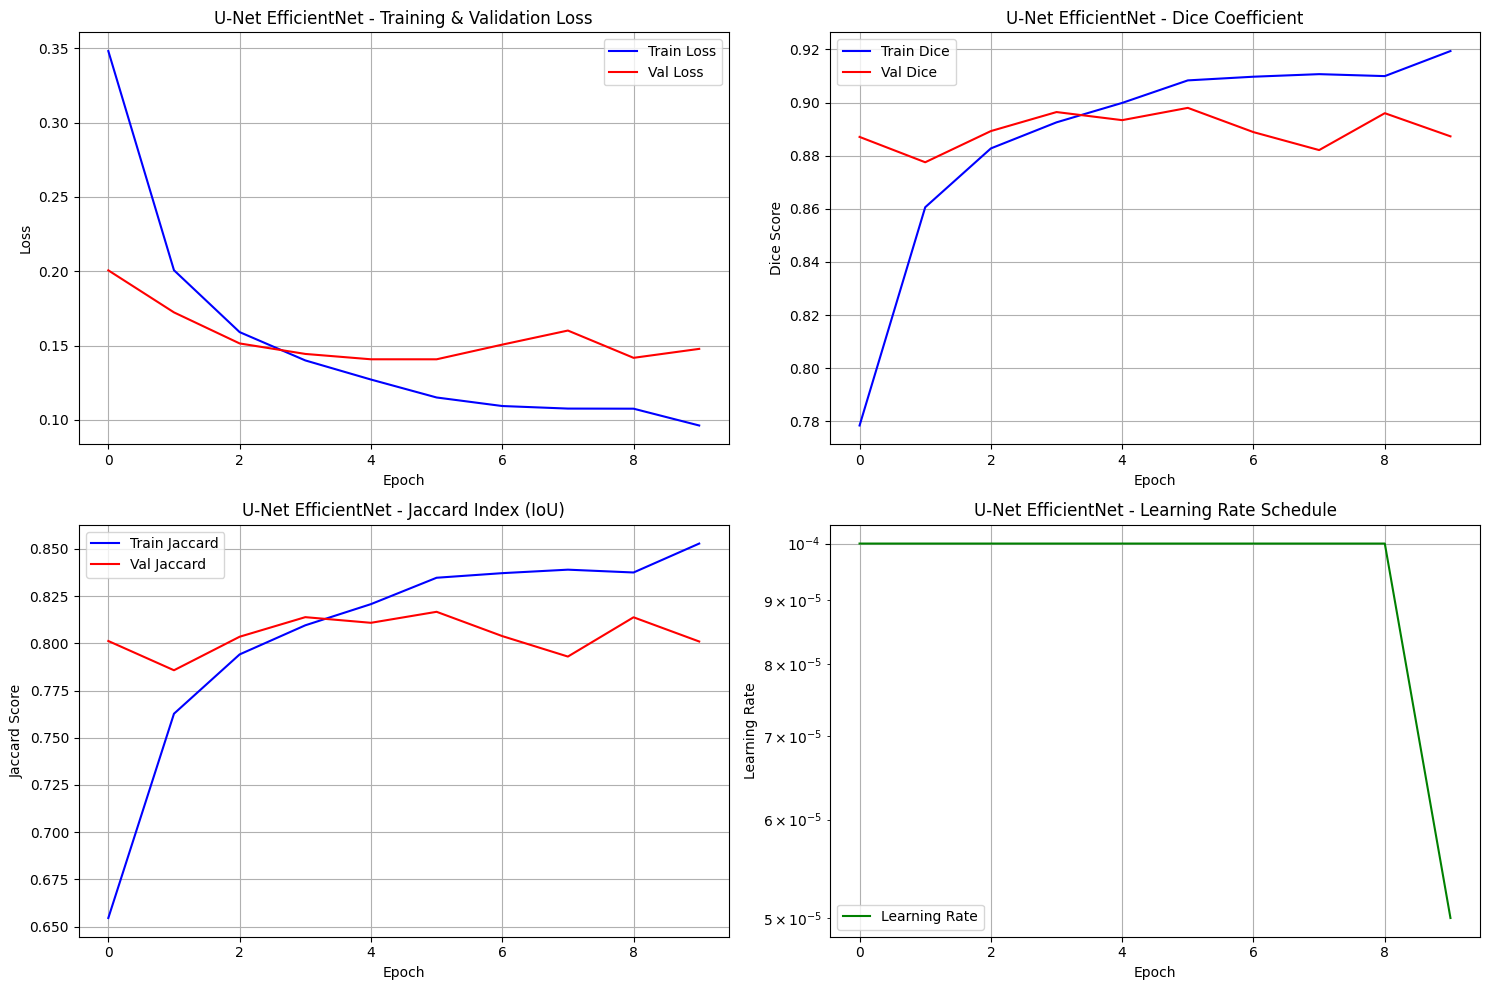

In [16]:
def plot_training_history(history, model_name="U-Net EfficientNet"):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['train_losses'], label='Train Loss', color='blue')
    axes[0, 0].plot(history['val_losses'], label='Val Loss', color='red')
    axes[0, 0].set_title(f'{model_name} - Training & Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', color='blue')
    axes[0, 1].plot(history['val_dice'], label='Val Dice', color='red')
    axes[0, 1].set_title(f'{model_name} - Dice Coefficient')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Jaccard Index
    axes[1, 0].plot(history['train_jaccard'], label='Train Jaccard', color='blue')
    axes[1, 0].plot(history['val_jaccard'], label='Val Jaccard', color='red')
    axes[1, 0].set_title(f'{model_name} - Jaccard Index (IoU)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Jaccard Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning Rate
    axes[1, 1].plot(history['learning_rates'], label='Learning Rate', color='green')
    axes[1, 1].set_title(f'{model_name} - Learning Rate Schedule')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    axes[1, 1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

# Plot training history
print("📊 Hiển thị training history:")
plot_training_history(unet_efficientnet_history, "U-Net EfficientNet")

🔍 Đánh giá model trên validation samples:


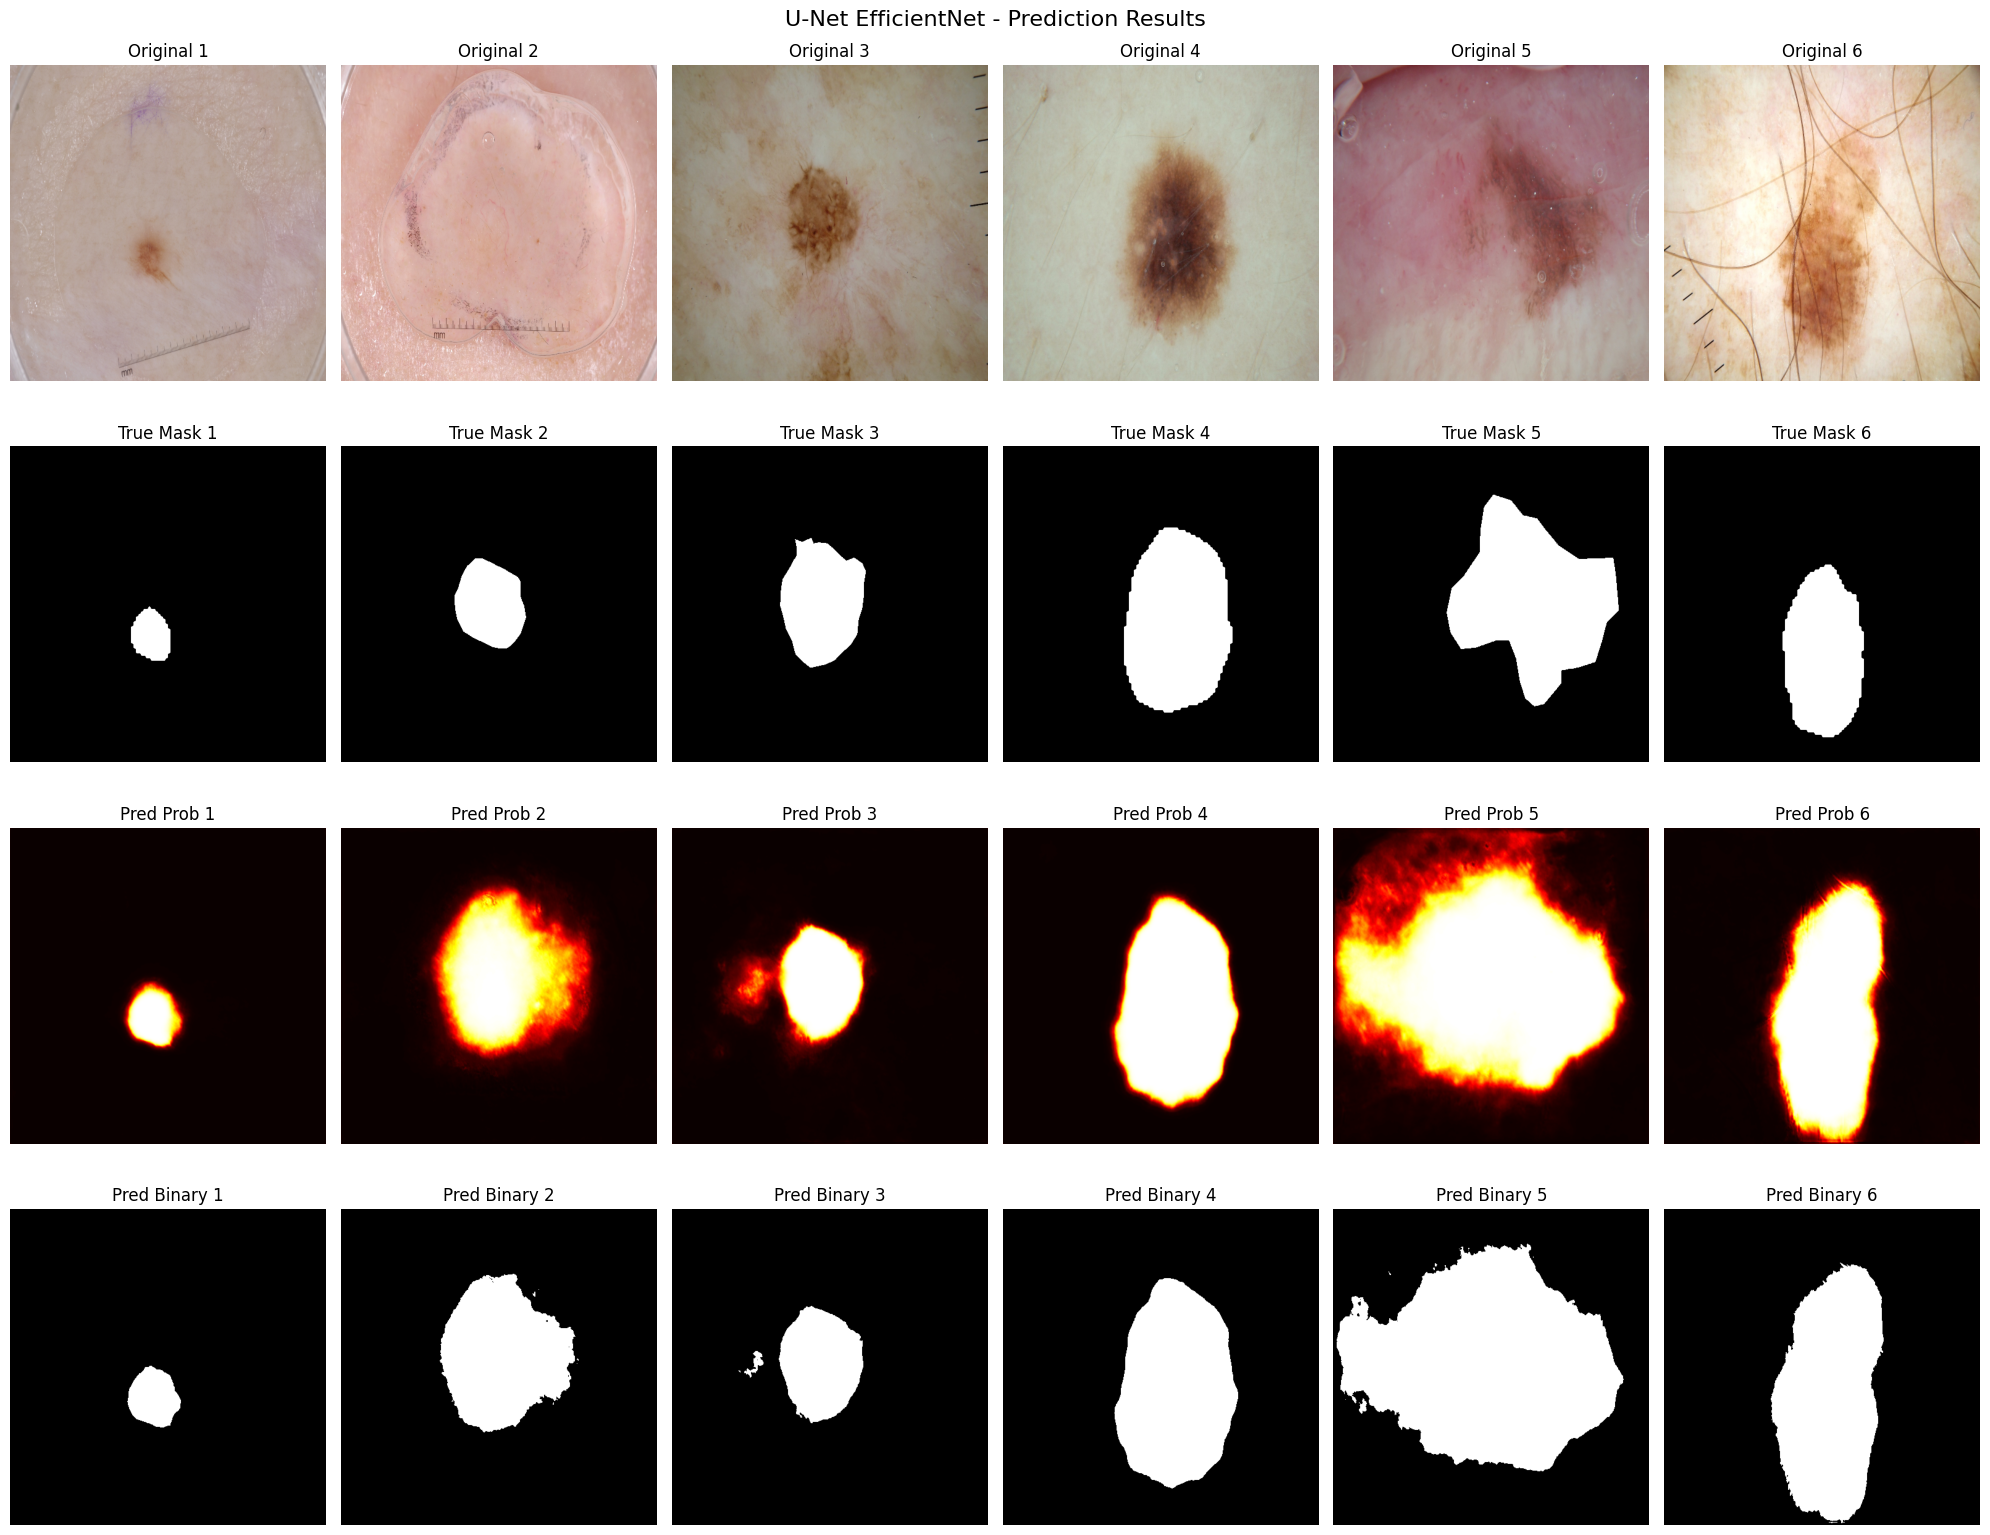

In [17]:
def evaluate_model_on_samples(model, val_loader, num_samples=6):
    """Evaluate model on sample images"""
    model.eval()
    
    # Get some samples
    samples = []
    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            if i >= num_samples // val_loader.batch_size + 1:
                break
                
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            
            for j in range(min(images.shape[0], num_samples - len(samples))):
                # Denormalize image for visualization
                img = images[j].cpu()
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img = img * std + mean
                img = torch.clamp(img, 0, 1)
                
                # Handle different tensor shapes
                if masks.dim() == 3:  # [batch, H, W]
                    true_mask = masks[j].cpu().numpy()
                else:  # [batch, 1, H, W]
                    true_mask = masks[j, 0].cpu().numpy()
                
                if outputs.dim() == 3:  # [batch, H, W]
                    pred_mask = outputs[j].cpu().numpy()
                    pred_binary = (outputs[j] > 0.5).cpu().numpy().astype(np.uint8)
                else:  # [batch, 1, H, W]
                    pred_mask = outputs[j, 0].cpu().numpy()
                    pred_binary = (outputs[j, 0] > 0.5).cpu().numpy().astype(np.uint8)
                
                samples.append({
                    'image': img.permute(1, 2, 0).numpy(),
                    'true_mask': true_mask,
                    'pred_mask': pred_mask,
                    'pred_binary': pred_binary
                })
                
                if len(samples) >= num_samples:
                    break
    
    # Visualize results
    fig, axes = plt.subplots(4, len(samples), figsize=(20, 16))
    
    for i, sample in enumerate(samples):
        # Original image
        axes[0, i].imshow(sample['image'])
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        # True mask
        axes[1, i].imshow(sample['true_mask'], cmap='gray')
        axes[1, i].set_title(f'True Mask {i+1}')
        axes[1, i].axis('off')
        
        # Predicted mask (probability)
        axes[2, i].imshow(sample['pred_mask'], cmap='hot', vmin=0, vmax=1)
        axes[2, i].set_title(f'Pred Prob {i+1}')
        axes[2, i].axis('off')
        
        # Predicted mask (binary)
        axes[3, i].imshow(sample['pred_binary'], cmap='gray')
        axes[3, i].set_title(f'Pred Binary {i+1}')
        axes[3, i].axis('off')
    
    plt.suptitle('U-Net EfficientNet - Prediction Results', fontsize=16)
    plt.tight_layout()
    plt.show()

# Evaluate model on samples
print("🔍 Đánh giá model trên validation samples:")
evaluate_model_on_samples(model, val_loader, num_samples=6)

## 8. Final Results Summary

In [18]:
# Print final results
print("🎯 U-NET EFFICIENTNET TRAINING RESULTS")
print("=" * 50)
print(f"📊 Final Metrics (Last Epoch):")
print(f"   - Training Loss: {unet_efficientnet_history['train_losses'][-1]:.4f}")
print(f"   - Validation Loss: {unet_efficientnet_history['val_losses'][-1]:.4f}")
print(f"   - Training Dice: {unet_efficientnet_history['train_dice'][-1]:.4f}")
print(f"   - Validation Dice: {unet_efficientnet_history['val_dice'][-1]:.4f}")
print(f"   - Training Jaccard: {unet_efficientnet_history['train_jaccard'][-1]:.4f}")
print(f"   - Validation Jaccard: {unet_efficientnet_history['val_jaccard'][-1]:.4f}")

print(f"\n🏆 Best Metrics:")
best_val_dice_idx = np.argmax(unet_efficientnet_history['val_dice'])
best_val_jaccard_idx = np.argmax(unet_efficientnet_history['val_jaccard'])
print(f"   - Best Validation Dice: {max(unet_efficientnet_history['val_dice']):.4f} (Epoch {best_val_dice_idx + 1})")
print(f"   - Best Validation Jaccard: {max(unet_efficientnet_history['val_jaccard']):.4f} (Epoch {best_val_jaccard_idx + 1})")

print(f"\n💾 Saved Models:")
print(f"   - models/unet_efficientnet_model_best.pth")
print(f"   - models/unet_efficientnet_model_final.pth")

print(f"\n📈 Model Performance:")
final_dice = unet_efficientnet_history['val_dice'][-1]
final_jaccard = unet_efficientnet_history['val_jaccard'][-1]

if final_dice > 0.85:
    print(f"   ✅ Excellent performance! Dice > 0.85")
elif final_dice > 0.80:
    print(f"   ✅ Good performance! Dice > 0.80")
elif final_dice > 0.75:
    print(f"   ⚠️  Acceptable performance. Dice > 0.75")
else:
    print(f"   ❌ Performance needs improvement. Dice < 0.75")

print(f"\n🚀 Next Steps:")
print(f"   1. Run 04_train_unet_vit.ipynb to train U-Net ViT")
print(f"   2. Run 05_train_deeplabv3_resnet.ipynb to train DeepLabV3+ ResNet")
print(f"   3. Compare all models' performance")

print("\n✅ U-Net EfficientNet training completed successfully!")

🎯 U-NET EFFICIENTNET TRAINING RESULTS
📊 Final Metrics (Last Epoch):
   - Training Loss: 0.0961
   - Validation Loss: 0.1477
   - Training Dice: 0.9194
   - Validation Dice: 0.8873
   - Training Jaccard: 0.8528
   - Validation Jaccard: 0.8009

🏆 Best Metrics:
   - Best Validation Dice: 0.8980 (Epoch 6)
   - Best Validation Jaccard: 0.8167 (Epoch 6)

💾 Saved Models:
   - models/unet_efficientnet_model_best.pth
   - models/unet_efficientnet_model_final.pth

📈 Model Performance:
   ✅ Excellent performance! Dice > 0.85

🚀 Next Steps:
   1. Run 04_train_unet_vit.ipynb to train U-Net ViT
   2. Run 05_train_deeplabv3_resnet.ipynb to train DeepLabV3+ ResNet
   3. Compare all models' performance

✅ U-Net EfficientNet training completed successfully!
